In [2]:
# packages
import numpy as np
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from utilities import dLambda
from solver_1d import false_transient_one_iteration_python
import global_parameters as gp
from supportfunctions import PDESolver_2d, finiteDiff
import matplotlib.pyplot as plt
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode

import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# BHmodified 1d
## With no Hotelling constraint
$$
\begin{aligned}
0 = \max_{\tilde e}\min_h & - \delta \phi(y) + \delta\eta \log\tilde e \\
&  + \frac{\xi_m}{2} h'h + \frac{d\phi(y)}{dy} \tilde e (\theta + \sigma_y h) + \frac{1}{2}\frac{d^2\phi(y)}{dy^2}|\sigma_y|^2(\tilde e)^2\\
& + (\eta -1 )\cdot(\gamma_1 + \gamma_2 y + \gamma_3 (y - \bar y)\mathcal{I}\{y>\bar y\})\cdot\tilde e\cdot (\theta + \sigma_y h)
  + \frac{1}{2}(\eta - 1)\cdot (\gamma_2 + \gamma_3 \mathcal{I}\{y > \bar y\}) (\tilde e )^2 |\sigma_y|^2
\end{aligned}
$$

$$
h^* = - \frac{\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)}{\xi_m}\tilde e \sigma_y
$$
Plug it  back to the HJB:
$$
\begin{aligned}
 0 = \max_{\tilde e} \quad - & \delta\phi(y) + \delta\eta \log\tilde e \\
 & + \frac{d\phi(y)}{dy}\tilde e \theta +  (\eta -1 )(\gamma_1 + \gamma_2 y)\tilde e \theta \\ 
 & + \left[- \frac{1}{2\xi_m}\left( \frac{d\phi(y)}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{1}{2}\frac{d^2\phi(y)}{dy^2} + \frac{1}{2}(\eta - 1)\cdot (\gamma_2 + \gamma_3 \mathcal{I}\{y > \bar y\})\right] \cdot (\tilde e)^2 |\sigma_y|^2
\end{aligned}
$$

First order condition for $\tilde e ^*$:
$$
  \left[- \frac{1}{\xi_m}\left( \frac{d\phi(y)}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2\phi(y)}{dy^2} + (\eta - 1)\cdot (\gamma_2 + \gamma_3 \mathcal{I}\{y > \bar y\})\right] \cdot|\sigma_y|^2\cdot(\tilde e)^2 + \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta\tilde e + \delta\eta = 0
$$

$$
A =  \left[- \frac{1}{\xi_m}\left( \frac{d\phi(y)}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2\phi(y)}{dy^2} + (\eta - 1)\cdot (\gamma_2 + \gamma_3 \mathcal{I}\{y > \bar y\})\right] \cdot|\sigma_y|^2
$$

$$
B = \left[\frac{d\phi(y)}{dy} + (\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta
$$

$$
C = \delta\eta
$$
And
$$
\tilde e^* = \frac{-B -  \sqrt{B^2 - 4AC}}{2A}
$$

In [3]:
# y grid
δ = 0.01
η = 0.032
ξₘ = 0.004
μ = 1.86/1000
θ = μ
σy = 1.2*θ
num_y = 200
y_min = 1e-10
y_max = 10
y_grid = np.linspace(y_min, y_max, num_y)
hy = y_grid[1] - y_grid[0]
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])

In [5]:
# no constraint ode
def solve_no_constraint(y_grid, args, tol=1e-8, ϵ=0.3):
    δ, η, θ, σy, γ1, γ2, γ3, ȳ, ξₘ = args
    hy = y_grid[1] - y_grid[0]
    # initialize the while loop
    episode = 0
    lhs_error = 1
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid - ȳ)*(y_grid>ȳ)
    ddΛ = γ2 + γ3*(y_grid > ȳ)
    ϕ =  - δ*η*y_grid**2
    ems = - δ*η/((η-1)*dΛ*θ)
    ems_old = ems
    h_star = 0
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, hy)
        dϕdyy = derivative_1d(ϕ, 2, hy)
        temp = dϕdy + (η-1)*dΛ
        a = (dϕdyy - temp**2/ξₘ + (η-1)*ddΛ)*σy**2
        b = temp*θ
        c = δ*η
        Δ = b**2 - 4*a*c
        Δ[Δ <0] = 0
        ems_new = (-b - np.sqrt(Δ))/(2*a)
        ems_new[ems_new <= 1e-15] = 1e-15    
        ems = ems_new*1 + ems_old*0
        # coefficients
        
        A = -δ*np.ones(y_grid.shape)
        B = ems*θ
#         C = np.zeros(y_grid.shape)
        C = σy**2*ems**2/2
        D = δ*η*np.log(ems) + (η-1)*dΛ*ems*θ \
        - 1/(2*ξₘ)*temp**2*ems**2*σy**2 \
        + 1/2*(η-1)*ddΛ*ems**2*σy**2

        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    return ϕ, ems

In [6]:
γ3 = np.average(γ3_list, weights=[0.5,0.5,0])
ϕdict = dict()
emsdict = dict()
for ξₘ in [0.002, 1000]:
    args = (δ, η, θ, σy, γ1, γ2, γ3, ȳ, ξₘ)
    ϕdict[ξₘ], emsdict[ξₘ] = solve_no_constraint(y_grid, args)

episode: 1,	 ode error: 0.0013140121319947338,	 ft error: 0.0012763174931804918
episode: 2,	 ode error: 0.0012672538402693366,	 ft error: 0.0012283731044846146
episode: 3,	 ode error: 0.0012230216218042224,	 ft error: 0.001187873331532034
episode: 4,	 ode error: 0.0011844662662835093,	 ft error: 0.0011534109741689429
episode: 5,	 ode error: 0.001150892813460243,	 ft error: 0.0011232154133233958
episode: 6,	 ode error: 0.0011213220671934389,	 ft error: 0.00109593894727515
episode: 7,	 ode error: 0.0010948365059863083,	 ft error: 0.0010720275182629737
episode: 8,	 ode error: 0.001071080455699242,	 ft error: 0.001050296816666804
episode: 9,	 ode error: 0.0010495204091127257,	 ft error: 0.0010304096900801156
episode: 10,	 ode error: 0.0010297781799208025,	 ft error: 0.0010120819579508276
episode: 11,	 ode error: 0.001011568134060586,	 ft error: 0.0009950861313641885
episode: 12,	 ode error: 0.0009946669750443258,	 ft error: 0.0009792393276780605
episode: 13,	 ode error: 0.00097889791850287

episode: 199,	 ode error: 0.00029964354214487895,	 ft error: 0.0002983095315046055
episode: 200,	 ode error: 0.00029806682433841235,	 ft error: 0.00029678397129725514
episode: 201,	 ode error: 0.00029649718847363736,	 ft error: 0.00029525995466861876
episode: 202,	 ode error: 0.00029493451351680184,	 ft error: 0.0002937380952834634
episode: 203,	 ode error: 0.0002933787447553599,	 ft error: 0.0002922190313268495
episode: 204,	 ode error: 0.0002918298712379624,	 ft error: 0.00029070336797581975
episode: 205,	 ode error: 0.0002902879087555349,	 ft error: 0.0002891916508148777
episode: 206,	 ode error: 0.0002887528877528234,	 ft error: 0.00028768435690722704
episode: 207,	 ode error: 0.00028722484516460376,	 ft error: 0.0002861818953735218
episode: 208,	 ode error: 0.00028570381916965886,	 ft error: 0.00028468461264012185
episode: 209,	 ode error: 0.00028418984601068687,	 ft error: 0.00028319279960539734
episode: 210,	 ode error: 0.0002826829582206164,	 ft error: 0.00028170669921105673
ep

episode: 416,	 ode error: 9.504883984355703e-05,	 ft error: 9.583012885931257e-05
episode: 417,	 ode error: 9.455995245966184e-05,	 ft error: 9.53417205811861e-05
episode: 418,	 ode error: 9.407372006458529e-05,	 ft error: 9.485596427431797e-05
episode: 419,	 ode error: 9.359012679174621e-05,	 ft error: 9.437284409954949e-05
episode: 420,	 ode error: 9.31091568662849e-05,	 ft error: 9.389234430922286e-05
episode: 421,	 ode error: 9.263079460483333e-05,	 ft error: 9.341444924637159e-05
episode: 422,	 ode error: 9.215502441541415e-05,	 ft error: 9.293914334534507e-05
episode: 423,	 ode error: 9.168183079725644e-05,	 ft error: 9.246641113095275e-05
episode: 424,	 ode error: 9.121119834062691e-05,	 ft error: 9.199623721885727e-05
episode: 425,	 ode error: 9.074311172669355e-05,	 ft error: 9.152860631511199e-05
episode: 426,	 ode error: 9.027755572734862e-05,	 ft error: 9.106350321620715e-05
episode: 427,	 ode error: 8.981451520504932e-05,	 ft error: 9.0600912808723e-05
episode: 428,	 ode e

episode: 642,	 ode error: 3.0155068589949826e-05,	 ft error: 3.0997169210127594e-05
episode: 643,	 ode error: 3.0001621506155012e-05,	 ft error: 3.084385773235536e-05
episode: 644,	 ode error: 2.9848928749787542e-05,	 ft error: 3.0691299983791796e-05
episode: 645,	 ode error: 2.969698673400392e-05,	 ft error: 3.053949238385201e-05
episode: 646,	 ode error: 2.954579189221962e-05,	 ft error: 3.038843137170381e-05
episode: 647,	 ode error: 2.9395340677791193e-05,	 ft error: 3.023811340663781e-05
episode: 648,	 ode error: 2.9245629563580855e-05,	 ft error: 3.008853496711909e-05
episode: 649,	 ode error: 2.9096655041649226e-05,	 ft error: 2.9939692550902862e-05
episode: 650,	 ode error: 2.8948413622860783e-05,	 ft error: 2.9791582674271178e-05
episode: 651,	 ode error: 2.8800901836547547e-05,	 ft error: 2.9644201871940428e-05
episode: 652,	 ode error: 2.8654116230147604e-05,	 ft error: 2.9497546696552468e-05
episode: 653,	 ode error: 2.850805336891964e-05,	 ft error: 2.935161371851273e-05
e

episode: 868,	 ode error: 9.232326883211223e-06,	 ft error: 1.009482407630935e-05
episode: 869,	 ode error: 9.181978526186219e-06,	 ft error: 1.0044532366947542e-05
episode: 870,	 ode error: 9.13187433452113e-06,	 ft error: 9.994484612002585e-06
episode: 871,	 ode error: 9.082013103783133e-06,	 ft error: 9.944679607807688e-06
episode: 872,	 ode error: 9.032393635954525e-06,	 ft error: 9.895116157311128e-06
episode: 873,	 ode error: 8.983014739346413e-06,	 ft error: 9.845793069683067e-06
episode: 874,	 ode error: 8.933875228575952e-06,	 ft error: 9.796709160500572e-06
episode: 875,	 ode error: 8.88497392452774e-06,	 ft error: 9.747863251493202e-06
episode: 876,	 ode error: 8.836309654299728e-06,	 ft error: 9.699254170658644e-06
episode: 877,	 ode error: 8.787881251191712e-06,	 ft error: 9.650880752216467e-06
episode: 878,	 ode error: 8.739687554646693e-06,	 ft error: 9.602741836492457e-06
episode: 879,	 ode error: 8.691727410206954e-06,	 ft error: 9.554836269802988e-06
episode: 880,	 od

episode: 1094,	 ode error: 4.66729617676256e-06,	 ft error: 4.105303807039329e-06
episode: 1095,	 ode error: 4.6549915724072854e-06,	 ft error: 4.093035464933226e-06
episode: 1096,	 ode error: 4.642723629335829e-06,	 ft error: 4.0808035821349176e-06
episode: 1097,	 ode error: 4.630492238969625e-06,	 ft error: 4.068608050987466e-06
episode: 1098,	 ode error: 4.618297293049677e-06,	 ft error: 4.0564487642040055e-06
episode: 1099,	 ode error: 4.60613868363439e-06,	 ft error: 4.044325614717403e-06
episode: 1100,	 ode error: 4.594016303100976e-06,	 ft error: 4.032238495853732e-06
episode: 1101,	 ode error: 4.581930044142424e-06,	 ft error: 4.02018730127444e-06
episode: 1102,	 ode error: 4.569879799767168e-06,	 ft error: 4.008171924814452e-06
episode: 1103,	 ode error: 4.557865463298823e-06,	 ft error: 3.996192260805979e-06
episode: 1104,	 ode error: 4.545886928373794e-06,	 ft error: 3.984248203720009e-06
episode: 1105,	 ode error: 4.533944088942906e-06,	 ft error: 3.972339648443865e-06
epis

episode: 1321,	 ode error: 2.6366042917682427e-06,	 ft error: 2.0813842303267958e-06
episode: 1322,	 ode error: 2.630362762055902e-06,	 ft error: 2.075162976166815e-06
episode: 1323,	 ode error: 2.624139855060537e-06,	 ft error: 2.068960215720339e-06
episode: 1324,	 ode error: 2.617935515534511e-06,	 ft error: 2.062775894355144e-06
episode: 1325,	 ode error: 2.6117496883929815e-06,	 ft error: 2.0566099576124763e-06
episode: 1326,	 ode error: 2.6055823187134106e-06,	 ft error: 2.0504623511723627e-06
episode: 1327,	 ode error: 2.599433351735891e-06,	 ft error: 2.044333020876736e-06
episode: 1328,	 ode error: 2.5933027328604343e-06,	 ft error: 2.03822191278726e-06
episode: 1329,	 ode error: 2.58719040764925e-06,	 ft error: 2.0321289730234246e-06
episode: 1330,	 ode error: 2.5810963218242497e-06,	 ft error: 2.0260541479013203e-06
episode: 1331,	 ode error: 2.5750204212678074e-06,	 ft error: 2.019997383979899e-06
episode: 1332,	 ode error: 2.5689626520216747e-06,	 ft error: 2.01395862782967

episode: 1547,	 ode error: 2.370523254333816e-06,	 ft error: 1.0584055210038912e-06
episode: 1548,	 ode error: 2.3706534035620704e-06,	 ft error: 1.0552447262413926e-06
episode: 1549,	 ode error: 2.3707802970918254e-06,	 ft error: 1.0520933182064005e-06
episode: 1550,	 ode error: 2.370903955997586e-06,	 ft error: 1.0489512691202094e-06
episode: 1551,	 ode error: 2.371024401246467e-06,	 ft error: 1.0458185514354106e-06
episode: 1552,	 ode error: 2.3711416536973252e-06,	 ft error: 1.0426951375930305e-06
episode: 1553,	 ode error: 2.371255734101357e-06,	 ft error: 1.0395810001150494e-06
episode: 1554,	 ode error: 2.3713666631011753e-06,	 ft error: 1.0364761116044008e-06
episode: 1555,	 ode error: 2.3714744612318944e-06,	 ft error: 1.0333804448837507e-06
episode: 1556,	 ode error: 2.371579148924979e-06,	 ft error: 1.0302939726485514e-06
episode: 1557,	 ode error: 2.371680746504287e-06,	 ft error: 1.0272166677561627e-06
episode: 1558,	 ode error: 2.3717792741876405e-06,	 ft error: 1.0241485

episode: 1774,	 ode error: 2.347479699184925e-06,	 ft error: 5.366092992870053e-07
episode: 1775,	 ode error: 2.347247799484853e-06,	 ft error: 5.350061323822208e-07
episode: 1776,	 ode error: 2.3470154171621044e-06,	 ft error: 5.33407728669592e-07
episode: 1777,	 ode error: 2.3467825582263032e-06,	 ft error: 5.31814074120988e-07
episode: 1778,	 ode error: 2.3465492286480426e-06,	 ft error: 5.302251546735841e-07
episode: 1779,	 ode error: 2.3463154343639258e-06,	 ft error: 5.286409563339441e-07
episode: 1780,	 ode error: 2.3460811812751024e-06,	 ft error: 5.270614652358452e-07
episode: 1781,	 ode error: 2.345846475245697e-06,	 ft error: 5.254866674089809e-07
episode: 1782,	 ode error: 2.345611322106928e-06,	 ft error: 5.239165490333875e-07
episode: 1783,	 ode error: 2.3453757276536936e-06,	 ft error: 5.223510962775365e-07
episode: 1784,	 ode error: 2.3451396976459805e-06,	 ft error: 5.207902953677235e-07
episode: 1785,	 ode error: 2.344903237808647e-06,	 ft error: 5.192341325418089e-07

episode: 1999,	 ode error: 2.291356980875926e-06,	 ft error: 2.736779126701524e-07
episode: 2000,	 ode error: 2.291115912484874e-06,	 ft error: 2.728598936264463e-07
episode: 2001,	 ode error: 2.290875071605245e-06,	 ft error: 2.720443062949792e-07
episode: 2002,	 ode error: 2.290634459443323e-06,	 ft error: 2.7123114347086624e-07
episode: 2003,	 ode error: 2.2903940771981266e-06,	 ft error: 2.70420398053306e-07
episode: 2004,	 ode error: 2.290153926055394e-06,	 ft error: 2.696120628836729e-07
episode: 2005,	 ode error: 2.2899140071908335e-06,	 ft error: 2.6880613083803595e-07
episode: 2006,	 ode error: 2.2896743217688787e-06,	 ft error: 2.6800259480402877e-07
episode: 2007,	 ode error: 2.289434870943554e-06,	 ft error: 2.672014476924149e-07
episode: 2008,	 ode error: 2.289195655858422e-06,	 ft error: 2.664026824949114e-07
episode: 2009,	 ode error: 2.2889566776469077e-06,	 ft error: 2.6560629212228165e-07
episode: 2010,	 ode error: 2.2887179374305095e-06,	 ft error: 2.6481226961250215

episode: 2225,	 ode error: 2.244039995039928e-06,	 ft error: 1.391582349583957e-07
episode: 2226,	 ode error: 2.2438656122623956e-06,	 ft error: 1.387424754713725e-07
episode: 2227,	 ode error: 2.2436915426184427e-06,	 ft error: 1.383279512925014e-07
episode: 2228,	 ode error: 2.2435177859609972e-06,	 ft error: 1.379146587557334e-07
episode: 2229,	 ode error: 2.2433443421392466e-06,	 ft error: 1.3750259426440853e-07
episode: 2230,	 ode error: 2.24317121100227e-06,	 ft error: 1.3709175414091299e-07
episode: 2231,	 ode error: 2.2429983923950804e-06,	 ft error: 1.3668213481171643e-07
episode: 2232,	 ode error: 2.242825886161065e-06,	 ft error: 1.3627373263389958e-07
episode: 2233,	 ode error: 2.242653692139762e-06,	 ft error: 1.3586654403393203e-07
episode: 2234,	 ode error: 2.2424818101691372e-06,	 ft error: 1.354605654614131e-07
episode: 2235,	 ode error: 2.242310240084121e-06,	 ft error: 1.3505579327342348e-07
episode: 2236,	 ode error: 2.242138981718234e-06,	 ft error: 1.3465222397738

episode: 2449,	 ode error: 2.2123362927850402e-06,	 ft error: 7.117875119172501e-08
episode: 2450,	 ode error: 2.21222519724651e-06,	 ft error: 7.096594781726603e-08
episode: 2451,	 ode error: 2.212114344627217e-06,	 ft error: 7.075377721210696e-08
episode: 2452,	 ode error: 2.212003734536794e-06,	 ft error: 7.0542237468052e-08
episode: 2453,	 ode error: 2.2118933665854707e-06,	 ft error: 7.033132680411835e-08
episode: 2454,	 ode error: 2.2117832403816874e-06,	 ft error: 7.012104331211022e-08
episode: 2455,	 ode error: 2.2116733555368117e-06,	 ft error: 6.991138510696142e-08
episode: 2456,	 ode error: 2.211563711657983e-06,	 ft error: 6.970238098508164e-08
episode: 2457,	 ode error: 2.21145430835516e-06,	 ft error: 6.949417166723926e-08
episode: 2458,	 ode error: 2.2113451452364027e-06,	 ft error: 6.9286580847705e-08
episode: 2459,	 ode error: 2.211236221910369e-06,	 ft error: 6.907960665297752e-08
episode: 2460,	 ode error: 2.211127537987722e-06,	 ft error: 6.887324734833333e-08
episo

episode: 2675,	 ode error: 2.1926718723076625e-06,	 ft error: 3.618881908260911e-08
episode: 2676,	 ode error: 2.19260596405821e-06,	 ft error: 3.6080640119136774e-08
episode: 2677,	 ode error: 2.1925402147279674e-06,	 ft error: 3.5972782761832064e-08
episode: 2678,	 ode error: 2.1924746239842478e-06,	 ft error: 3.586524608550912e-08
episode: 2679,	 ode error: 2.1924091914967488e-06,	 ft error: 3.575802908402833e-08
episode: 2680,	 ode error: 2.192343916932024e-06,	 ft error: 3.565113089002796e-08
episode: 2681,	 ode error: 2.1922787999592293e-06,	 ft error: 3.554455052049803e-08
episode: 2682,	 ode error: 2.1922138402496886e-06,	 ft error: 3.543828705025269e-08
episode: 2683,	 ode error: 2.192149037472883e-06,	 ft error: 3.5332339507846796e-08
episode: 2684,	 ode error: 2.1920843912986727e-06,	 ft error: 3.5226707014353785e-08
episode: 2685,	 ode error: 2.192019901398924e-06,	 ft error: 3.5121388609893334e-08
episode: 2686,	 ode error: 2.191955567444582e-06,	 ft error: 3.5016383369279

episode: 2902,	 ode error: 2.1811988663573262e-06,	 ft error: 1.834266583529883e-08
episode: 2903,	 ode error: 2.1811614220753847e-06,	 ft error: 1.8287831862288478e-08
episode: 2904,	 ode error: 2.181124073467617e-06,	 ft error: 1.8233160918590396e-08
episode: 2905,	 ode error: 2.1810868203078586e-06,	 ft error: 1.8178652506917192e-08
episode: 2906,	 ode error: 2.181049662372005e-06,	 ft error: 1.812430616467594e-08
episode: 2907,	 ode error: 2.1810125994349756e-06,	 ft error: 1.8070121406144057e-08
episode: 2908,	 ode error: 2.180975631273154e-06,	 ft error: 1.801609778029345e-08
episode: 2909,	 ode error: 2.1809387576637905e-06,	 ft error: 1.7962234778271895e-08
episode: 2910,	 ode error: 2.180901978385112e-06,	 ft error: 1.7908531914356818e-08
episode: 2911,	 ode error: 2.1808652932112788e-06,	 ft error: 1.7854988760649764e-08
episode: 2912,	 ode error: 2.1808287019226317e-06,	 ft error: 1.7801604819863335e-08
episode: 2913,	 ode error: 2.1807922042965298e-06,	 ft error: 1.77483796

episode: 17,	 ode error: 0.0009527169036880304,	 ft error: 0.0009398786285316705
episode: 18,	 ode error: 0.0009410618968271466,	 ft error: 0.0009287747524227223
episode: 19,	 ode error: 0.0009299149448957206,	 ft error: 0.0009181308827227539
episode: 20,	 ode error: 0.0009192305068764836,	 ft error: 0.000907907705526015
episode: 21,	 ode error: 0.000908968910721786,	 ft error: 0.000898070704384215
episode: 22,	 ode error: 0.0008990953827673163,	 ft error: 0.0008885894215668842
episode: 23,	 ode error: 0.0008895809285213638,	 ft error: 0.0008788852632090217
episode: 24,	 ode error: 0.0008803483712566638,	 ft error: 0.0008701297065266967
episode: 25,	 ode error: 0.0008714478397785483,	 ft error: 0.0008616337778113674
episode: 26,	 ode error: 0.0008628449966645933,	 ft error: 0.0008533910872496303
episode: 27,	 ode error: 0.0008545143536228636,	 ft error: 0.0008453868989584448
episode: 28,	 ode error: 0.000846435207348491,	 ft error: 0.0008376066001114051
episode: 29,	 ode error: 0.00083

episode: 213,	 ode error: 0.00029373473713305645,	 ft error: 0.0002935818199254851
episode: 214,	 ode error: 0.00029221536960220254,	 ft error: 0.00029207538493070584
episode: 215,	 ode error: 0.00029070618618056896,	 ft error: 0.0002897367476272644
episode: 216,	 ode error: 0.0002891962110785016,	 ft error: 0.0002882268751708966
episode: 217,	 ode error: 0.0002876955779595673,	 ft error: 0.0002867291952933504
episode: 218,	 ode error: 0.00028620388895581614,	 ft error: 0.00028524227691860415
episode: 219,	 ode error: 0.0002847208227489711,	 ft error: 0.0002837651426593665
episode: 220,	 ode error: 0.000283246121081969,	 ft error: 0.0002822971149549677
episode: 221,	 ode error: 0.0002817795760599758,	 ft error: 0.0002808377154980372
episode: 222,	 ode error: 0.00028032101929030323,	 ft error: 0.0002793865996807606
episode: 223,	 ode error: 0.0002788703130497286,	 ft error: 0.0002779435136626476
episode: 224,	 ode error: 0.0002774273433048417,	 ft error: 0.0002765082660147883
episode: 2

episode: 421,	 ode error: 0.00010182015783077099,	 ft error: 0.00010173788865482092
episode: 422,	 ode error: 0.0001013179449396805,	 ft error: 0.00010123731348660644
episode: 423,	 ode error: 0.00010081835575314539,	 ft error: 0.0001007393448933247
episode: 424,	 ode error: 0.00010032137576393169,	 ft error: 0.0001002439685985022
episode: 425,	 ode error: 9.982699055469623e-05,	 ft error: 9.975117041020425e-05
episode: 426,	 ode error: 9.933518579720855e-05,	 ft error: 9.926093622260787e-05
episode: 427,	 ode error: 9.884594725153076e-05,	 ft error: 9.877325201280984e-05
episode: 428,	 ode error: 9.8359260765255e-05,	 ft error: 9.828810384216828e-05
episode: 429,	 ode error: 9.787511227267844e-05,	 ft error: 9.78054778539896e-05
episode: 430,	 ode error: 9.739348779403919e-05,	 ft error: 9.732536027392177e-05
episode: 431,	 ode error: 9.691437343469032e-05,	 ft error: 9.684773740919103e-05
episode: 432,	 ode error: 9.643775538433679e-05,	 ft error: 9.63725956465202e-05
episode: 433,	 

episode: 633,	 ode error: 3.672871632729748e-05,	 ft error: 3.67735195218553e-05
episode: 634,	 ode error: 3.655608555197748e-05,	 ft error: 3.660067086184068e-05
episode: 635,	 ode error: 3.6384285427085486e-05,	 ft error: 3.642864392773097e-05
episode: 636,	 ode error: 3.621331175593574e-05,	 ft error: 3.625743445266154e-05
episode: 637,	 ode error: 3.6043160366970714e-05,	 ft error: 3.608703819500218e-05
episode: 638,	 ode error: 3.5873827113548726e-05,	 ft error: 3.5917450934841444e-05
episode: 639,	 ode error: 3.5705307873766e-05,	 ft error: 3.574866847743293e-05
episode: 640,	 ode error: 3.553759855020905e-05,	 ft error: 3.558068664755165e-05
episode: 641,	 ode error: 3.537069506981774e-05,	 ft error: 3.541350129363426e-05
episode: 642,	 ode error: 3.520459338361291e-05,	 ft error: 3.52471082886117e-05
episode: 643,	 ode error: 3.503928946656991e-05,	 ft error: 3.508150352313222e-05
episode: 644,	 ode error: 3.487477931736526e-05,	 ft error: 3.491668291291661e-05
episode: 645,	 o

episode: 844,	 ode error: 1.3765034202941587e-05,	 ft error: 1.3781824493366845e-05
episode: 845,	 ode error: 1.3701047416483036e-05,	 ft error: 1.371795273950871e-05
episode: 846,	 ode error: 1.3637356260852353e-05,	 ft error: 1.3654375203980829e-05
episode: 847,	 ode error: 1.3573959232141323e-05,	 ft error: 1.359109044217488e-05
episode: 848,	 ode error: 1.351085490513442e-05,	 ft error: 1.3528097100428313e-05
episode: 849,	 ode error: 1.3448041911714548e-05,	 ft error: 1.3465393887898691e-05
episode: 850,	 ode error: 1.3385518925067828e-05,	 ft error: 1.3402979556625949e-05
episode: 851,	 ode error: 1.3323284648231073e-05,	 ft error: 1.3340852887192e-05
episode: 852,	 ode error: 1.3261337805687266e-05,	 ft error: 1.3279012678890645e-05
episode: 853,	 ode error: 1.3199677137357342e-05,	 ft error: 1.3217457742071653e-05
episode: 854,	 ode error: 1.313830139425395e-05,	 ft error: 1.3156186892682165e-05
episode: 855,	 ode error: 1.3077209335343233e-05,	 ft error: 1.3095198950046258e-05

episode: 1051,	 ode error: 5.390164431808963e-06,	 ft error: 5.67512581081675e-06
episode: 1052,	 ode error: 5.375903374778745e-06,	 ft error: 5.649313050369124e-06
episode: 1053,	 ode error: 5.361712562829927e-06,	 ft error: 5.6236201455284185e-06
episode: 1054,	 ode error: 5.34759198908487e-06,	 ft error: 5.5980457295407016e-06
episode: 1055,	 ode error: 5.3335416430192796e-06,	 ft error: 5.572588470462159e-06
episode: 1056,	 ode error: 5.319561510035132e-06,	 ft error: 5.547247068452925e-06
episode: 1057,	 ode error: 5.305651571192553e-06,	 ft error: 5.522020239516942e-06
episode: 1058,	 ode error: 5.2918118033343405e-06,	 ft error: 5.496906735971696e-06
episode: 1059,	 ode error: 5.278042178667296e-06,	 ft error: 5.4719053284996155e-06
episode: 1060,	 ode error: 5.264342664763151e-06,	 ft error: 5.4470148408194054e-06
episode: 1061,	 ode error: 5.250713223732724e-06,	 ft error: 5.422234092417044e-06
episode: 1062,	 ode error: 5.237153812924207e-06,	 ft error: 5.397561950494975e-06


episode: 1263,	 ode error: 3.588475977183347e-06,	 ft error: 1.9847916773544734e-06
episode: 1264,	 ode error: 3.58377610382328e-06,	 ft error: 1.9738729587862975e-06
episode: 1265,	 ode error: 3.5790974852822986e-06,	 ft error: 1.9630095774806717e-06
episode: 1266,	 ode error: 3.5744400138462175e-06,	 ft error: 1.9522015003622015e-06
episode: 1267,	 ode error: 3.5698035832063034e-06,	 ft error: 1.9414486918806206e-06
episode: 1268,	 ode error: 3.5651880883922705e-06,	 ft error: 1.930751110402566e-06
episode: 1269,	 ode error: 3.560593425808601e-06,	 ft error: 1.9201087104320225e-06
episode: 1270,	 ode error: 3.5560194931952976e-06,	 ft error: 1.9095214431885665e-06
episode: 1271,	 ode error: 3.5514661895846237e-06,	 ft error: 1.8989892541093623e-06
episode: 1272,	 ode error: 3.546933415310969e-06,	 ft error: 1.8885120843988488e-06
episode: 1273,	 ode error: 3.542421071992853e-06,	 ft error: 1.8780898716069805e-06
episode: 1274,	 ode error: 3.537929062486086e-06,	 ft error: 1.867722547

episode: 1475,	 ode error: 2.9570954947684977e-06,	 ft error: 9.439496695869595e-07
episode: 1476,	 ode error: 2.9554386428298643e-06,	 ft error: 9.411399081009816e-07
episode: 1477,	 ode error: 2.9537907498530585e-06,	 ft error: 9.383386540343097e-07
episode: 1478,	 ode error: 2.952151775015917e-06,	 ft error: 9.355458818286848e-07
episode: 1479,	 ode error: 2.950521677685036e-06,	 ft error: 9.327615648503189e-07
episode: 1480,	 ode error: 2.948900417368283e-06,	 ft error: 9.299856780266754e-07
episode: 1481,	 ode error: 2.9472879537760554e-06,	 ft error: 9.272181955219394e-07
episode: 1482,	 ode error: 2.9456842467761755e-06,	 ft error: 9.244590913846478e-07
episode: 1483,	 ode error: 2.9440892563933506e-06,	 ft error: 9.217083393510869e-07
episode: 1484,	 ode error: 2.9425029427973537e-06,	 ft error: 9.18965915146693e-07
episode: 1485,	 ode error: 2.940925266368727e-06,	 ft error: 9.162317926580954e-07
episode: 1486,	 ode error: 2.93935618763026e-06,	 ft error: 9.135059463385997e-07

episode: 1686,	 ode error: 2.7541115714378468e-06,	 ft error: 5.048328585027795e-07
episode: 1687,	 ode error: 2.753646313747942e-06,	 ft error: 5.033403538875122e-07
episode: 1688,	 ode error: 2.7531841879151154e-06,	 ft error: 5.018521864278795e-07
episode: 1689,	 ode error: 2.7527251772017794e-06,	 ft error: 5.003683431944091e-07
episode: 1690,	 ode error: 2.7522692649504686e-06,	 ft error: 4.988888116623976e-07
episode: 1691,	 ode error: 2.7518164345944653e-06,	 ft error: 4.9741357939966e-07
episode: 1692,	 ode error: 2.751366669654764e-06,	 ft error: 4.959426337658446e-07
episode: 1693,	 ode error: 2.7509199537406126e-06,	 ft error: 4.944759619933866e-07
episode: 1694,	 ode error: 2.7504762705304322e-06,	 ft error: 4.930135516385363e-07
episode: 1695,	 ode error: 2.750035603789813e-06,	 ft error: 4.915553900956364e-07
episode: 1696,	 ode error: 2.7495979373644676e-06,	 ft error: 4.901014656148266e-07
episode: 1697,	 ode error: 2.749163255204518e-06,	 ft error: 4.88651765625144e-07

episode: 1897,	 ode error: 2.7051497267133228e-06,	 ft error: 2.69680471380133e-07
episode: 1898,	 ode error: 2.7050778693497304e-06,	 ft error: 2.6887878212117355e-07
episode: 1899,	 ode error: 2.705006977140635e-06,	 ft error: 2.6807944757586044e-07
episode: 1900,	 ode error: 2.7049370443320677e-06,	 ft error: 2.6728246085155893e-07
episode: 1901,	 ode error: 2.704868065188273e-06,	 ft error: 2.664878147780788e-07
episode: 1902,	 ode error: 2.7048000339914948e-06,	 ft error: 2.6569550321449886e-07
episode: 1903,	 ode error: 2.704732945074499e-06,	 ft error: 2.649055197192126e-07
episode: 1904,	 ode error: 2.7046667928070246e-06,	 ft error: 2.6411785704107593e-07
episode: 1905,	 ode error: 2.7046015715613027e-06,	 ft error: 2.633325086228341e-07
episode: 1906,	 ode error: 2.704537275746645e-06,	 ft error: 2.625494682079177e-07
episode: 1907,	 ode error: 2.704473899808684e-06,	 ft error: 2.6176872856831235e-07
episode: 1908,	 ode error: 2.7044114382031347e-06,	 ft error: 2.609902835168

episode: 2109,	 ode error: 2.704431679846132e-06,	 ft error: 1.4333714584470933e-07
episode: 2110,	 ode error: 2.7044712107381465e-06,	 ft error: 1.4291016865268052e-07
episode: 2111,	 ode error: 2.704510957366119e-06,	 ft error: 1.4248445155221984e-07
episode: 2112,	 ode error: 2.704550917825648e-06,	 ft error: 1.4205999009087034e-07
episode: 2113,	 ode error: 2.7045910901940095e-06,	 ft error: 1.4163678106517605e-07
episode: 2114,	 ode error: 2.7046314725750423e-06,	 ft error: 1.4121482047370812e-07
episode: 2115,	 ode error: 2.7046720630712843e-06,	 ft error: 1.4079410506675125e-07
episode: 2116,	 ode error: 2.704712859814438e-06,	 ft error: 1.4037463115512683e-07
episode: 2117,	 ode error: 2.7047538609446635e-06,	 ft error: 1.3995639506122112e-07
episode: 2118,	 ode error: 2.7047950646035294e-06,	 ft error: 1.3953939270265153e-07
episode: 2119,	 ode error: 2.7048364689260997e-06,	 ft error: 1.391236208181379e-07
episode: 2120,	 ode error: 2.7048780720758444e-06,	 ft error: 1.387090

episode: 2321,	 ode error: 2.7153518685676253e-06,	 ft error: 7.611300329585236e-08
episode: 2322,	 ode error: 2.7154073596038705e-06,	 ft error: 7.588584198525705e-08
episode: 2323,	 ode error: 2.7154628334530176e-06,	 ft error: 7.565935205890625e-08
episode: 2324,	 ode error: 2.7155182895982274e-06,	 ft error: 7.54335318514654e-08
episode: 2325,	 ode error: 2.7155737275377312e-06,	 ft error: 7.520837898058094e-08
episode: 2326,	 ode error: 2.715629146756316e-06,	 ft error: 7.498389211629819e-08
episode: 2327,	 ode error: 2.715684546768151e-06,	 ft error: 7.476006845992997e-08
episode: 2328,	 ode error: 2.7157399270559632e-06,	 ft error: 7.453690677404017e-08
episode: 2329,	 ode error: 2.71579528713403e-06,	 ft error: 7.431440491913652e-08
episode: 2330,	 ode error: 2.7158506265131596e-06,	 ft error: 7.409256124144929e-08
episode: 2331,	 ode error: 2.7159059447197723e-06,	 ft error: 7.38713732429767e-08
episode: 2332,	 ode error: 2.715961241254593e-06,	 ft error: 7.365083913117114e-08

episode: 2533,	 ode error: 2.726174820941998e-06,	 ft error: 4.038306832450841e-08
episode: 2534,	 ode error: 2.7262196689479493e-06,	 ft error: 4.026248788073043e-08
episode: 2535,	 ode error: 2.7262644495735545e-06,	 ft error: 4.014226407296947e-08
episode: 2536,	 ode error: 2.7263091627623267e-06,	 ft error: 4.002239561753015e-08
episode: 2537,	 ode error: 2.7263538084552853e-06,	 ft error: 3.9902882479718e-08
episode: 2538,	 ode error: 2.7263983866329146e-06,	 ft error: 3.978372265881862e-08
episode: 2539,	 ode error: 2.726442897232873e-06,	 ft error: 3.9664915102433085e-08
episode: 2540,	 ode error: 2.7264873401981315e-06,	 ft error: 3.9546459718042826e-08
episode: 2541,	 ode error: 2.726531715512427e-06,	 ft error: 3.9428354666840956e-08
episode: 2542,	 ode error: 2.7265760231177548e-06,	 ft error: 3.931059883860444e-08
episode: 2543,	 ode error: 2.726620262963916e-06,	 ft error: 3.919319148161978e-08
episode: 2544,	 ode error: 2.7266644350107958e-06,	 ft error: 3.907613192512723

episode: 2745,	 ode error: 2.7341677230262275e-06,	 ft error: 2.1411758835872728e-08
episode: 2746,	 ode error: 2.7341984318539608e-06,	 ft error: 2.134771429074256e-08
episode: 2747,	 ode error: 2.734229078899626e-06,	 ft error: 2.128385939714761e-08
episode: 2748,	 ode error: 2.7342596642261066e-06,	 ft error: 2.1220194455773278e-08
episode: 2749,	 ode error: 2.734290187933583e-06,	 ft error: 2.115671780128503e-08
episode: 2750,	 ode error: 2.7343206500685677e-06,	 ft error: 2.1093429156127108e-08
episode: 2751,	 ode error: 2.734351050696763e-06,	 ft error: 2.103032843934575e-08
episode: 2752,	 ode error: 2.734381389901978e-06,	 ft error: 2.0967454312144827e-08
episode: 2753,	 ode error: 2.7344116677518668e-06,	 ft error: 2.0904808486118163e-08
episode: 2754,	 ode error: 2.734441884335334e-06,	 ft error: 2.0842347870734617e-08
episode: 2755,	 ode error: 2.7344720397124442e-06,	 ft error: 2.0780072373475605e-08
episode: 2756,	 ode error: 2.734502133963537e-06,	 ft error: 2.07179811269

episode: 2957,	 ode error: 2.7394196753632296e-06,	 ft error: 1.1347273757196982e-08
episode: 2958,	 ode error: 2.7394390782894355e-06,	 ft error: 1.1313317811502873e-08
episode: 2959,	 ode error: 2.7394584367456797e-06,	 ft error: 1.1279462676372365e-08
episode: 2960,	 ode error: 2.7394777508186986e-06,	 ft error: 1.1245707906559765e-08
episode: 2961,	 ode error: 2.7394970205852536e-06,	 ft error: 1.1212053212944495e-08
episode: 2962,	 ode error: 2.739516246124925e-06,	 ft error: 1.1178498375794914e-08
episode: 2963,	 ode error: 2.73953542751892e-06,	 ft error: 1.1145043181161792e-08
episode: 2964,	 ode error: 2.7395545648552753e-06,	 ft error: 1.1111687345706963e-08
episode: 2965,	 ode error: 2.7395736582173664e-06,	 ft error: 1.1078430169758624e-08
episode: 2966,	 ode error: 2.7395927076721968e-06,	 ft error: 1.104527184991877e-08
episode: 2967,	 ode error: 2.739611713310189e-06,	 ft error: 1.1012211842640712e-08
episode: 2968,	 ode error: 2.73963067521049e-06,	 ft error: 1.09792500

In [7]:
# compute hˢ
def compute_h_star(ϕ, ems, y_grid, args):
    η, σy, γ1, γ2, ξₘ = args
    dy = y_grid[1] - y_grid[0]
    dϕdy = derivative_1d(ϕ, 1, dy)
    dΛ = γ1 + γ2*y_grid
    h_star = dϕdy + (η-1)*dΛ
    h_star *= ems*σy
    h_star *= - 1/ξₘ
    return h_star

In [8]:
hˢdict = dict()
for ξₘ in [0.002, 1000]:
    args=(η, σy, γ1, γ2, ξₘ)
    hˢdict[ξₘ] = compute_h_star(ϕdict[ξₘ], emsdict[ξₘ], y_grid, args)

In [9]:
@njit
def simulate_ems(y_grid, ems, h_star, θ,  dt=1, T=100):
    periods = int(T/dt)
    ems_t = np.zeros(periods)
    y_t = np.zeros(periods)
    h_t = np.zeros(periods)
    y0 = θ*290
    y = y0
    for t in range(periods):
        ems_point = np.interp(y, y_grid, ems)
        h_point = np.interp(y, y_grid, h_star)
        ems_t[t] = ems_point
        h_t[t] = h_point
        dy = ems_point*θ*dt
        y = dy + y
        y_t[t] = y
    return y_t, ems_t, h_t

In [10]:
years = np.arange(0, 100, 1/4)
ytdict = dict()
etdict = dict()
htdict = dict()
for ξₘ in [0.002, 1000]:
    ytdict[ξₘ],etdict[ξₘ], htdict[ξₘ] = simulate_ems(y_grid, emsdict[ξₘ], hˢdict[ξₘ], θ, dt=1/4)

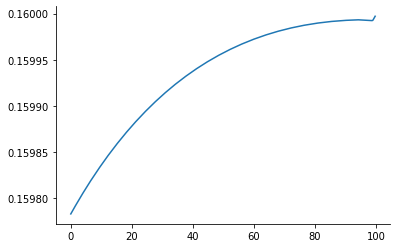

In [11]:
plt.plot(years, htdict[0.002])

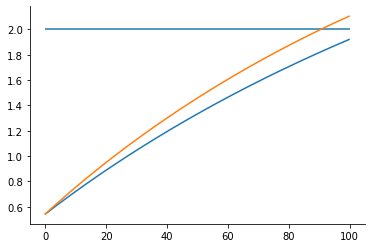

In [12]:
plt.plot(years,ytdict[0.002])
plt.plot(years, ytdict[1000])
plt.hlines(y=2,xmin=0,xmax=100)

(0.0, 14.0)

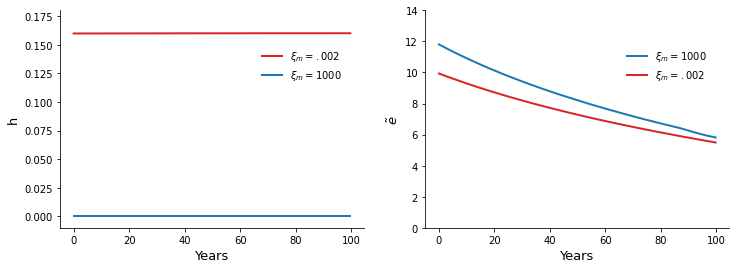

In [13]:
# plot 1
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
ax1.plot(years, htdict[0.002], color='C3', label=r'$\xi_m = .002$', linewidth=2.)
ax1.plot(years, htdict[1000], color='C0', label=r'$\xi_m = 1000$', linewidth=2.)
ax1.set_xlabel('Years', fontsize=13)
ax1.set_ylabel('h', fontsize=13)
ax1.legend(frameon=False, loc=(0.65,.65))
ax1.set_ylim(-0.01, 0.18)

ax2.plot(years, etdict[1000], color='C0', label=r'$\xi_m = 1000$', linewidth=2.)
ax2.plot(years, etdict[0.002], color='C3', label=r'$\xi_m = .002$', linewidth=2.)

ax2.set_xlabel('Years', fontsize=13)
ax2.set_ylabel(r'$\tilde{e}$', fontsize=13)
ax2.legend(frameon=False, loc=(0.65,.65))
ax2.set_ylim(0., 14.)

# fig.savefig('../figures/h_ems.pdf')

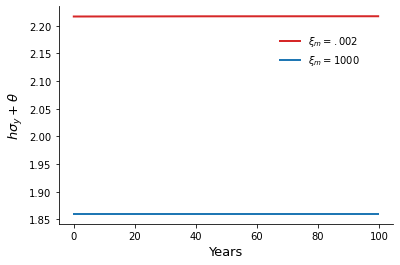

In [14]:
# plot 2
fig, ax1  = plt.subplots(1, 1,figsize=(6,4))
ax1.plot(years, (htdict[0.002]*σy + θ)*1000, color='C3', label=r'$\xi_m = .002$', linewidth=2.)
ax1.plot(years, (htdict[1000]*σy + θ)*1000, color='C0', label=r'$\xi_m = 1000$', linewidth=2.)
ax1.set_xlabel('Years', fontsize=13)
ax1.set_ylabel('$h\sigma_y + θ$', fontsize=13)
ax1.legend(frameon=False, loc=(0.65,.7))
# ax1.set_ylim(-0.01, 0.12)

# ax2.plot(years, etdict[0.004], color='C3', label=r'$\xi_m = .004$', linewidth=2.)
# ax2.plot(years, etdict[1000], color='C0', label=r'$\xi_m = 1000$', linewidth=2.)
# ax2.set_xlabel('Years', fontsize=13)
# ax2.set_ylabel(r'$\tilde{e}$', fontsize=13)
# ax2.legend(frameon=False, loc=(0.65,.7))
# ax2.set_ylim(0., 14.)

# fig.savefig('../figures/hsigma_theta.pdf')

## With hotelling constraint
$$
\begin{aligned}
0 = \max_{\tilde e}\min_h & \quad b \delta\eta \log\tilde e \\
&  + b \frac{\xi_m}{2} h'h + \frac{dV}{dy} \tilde e (\theta + \sigma_y h) - \delta b \frac{dV}{db} + \frac{1}{2}\frac{d^2V}{dy^2}|\sigma_y|^2(\tilde e)^2\\
                           & + b(\eta -1 )\cdot(\gamma_1 + \gamma_2 y)\cdot\tilde e\cdot (\theta + \sigma_y h) - \ell \tilde e
\end{aligned}
$$

$$
h^* = - \frac{\frac{dV}{dy} + b(\eta-1)(\gamma_1 + \gamma_2 y)}{b \xi_m} \cdot \tilde e \sigma_y
$$
Plug back into the HJB:
$$
\begin{aligned}
0 = \max_{\tilde e } \quad & b \delta\eta \log \tilde e + \frac{dV}{dy} \tilde e \theta - \delta b \frac{dV}{db} + \frac{1}{2}\frac{d^2V}{dy^2}|\sigma_y|^2(\tilde e)^2 \\ 
& +  b(\eta -1 )\cdot(\gamma_1 + \gamma_2 y)\cdot\tilde e\cdot \theta - \ell \tilde e \\
& -\frac{1}{2b\xi_m}\left(\frac{dV}{dy} + b(\eta-1)(\gamma_1 + \gamma_2 y)\right)^2 (\tilde e)^2 |\sigma_y|^2
\end{aligned}
$$
First order condition for $\tilde e ^*$:
$$
  \left[- \frac{1}{b\xi_m}\left( \frac{dV}{dy}  + b(\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2V}{dy^2}\right] \cdot|\sigma_y|^2\cdot(\tilde e)^2 + \left[\frac{dV}{dy}\theta + b(\eta - 1)(\gamma_1 + \gamma_2 y)\theta - \ell \right]\tilde e + b \delta\eta = 0
$$

$$
A =  \left[- \frac{1}{b\xi_m}\left( \frac{dV}{dy}  + b(\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2V}{dy^2}\right] \cdot|\sigma_y|^2
$$

$$
B = \left[\frac{dV}{dy} + b(\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta - \ell
$$ 

$$
C = b \delta\eta
$$
And
$$
\tilde e^* = \frac{-B -  \sqrt{B^2 - 4AC}}{2A}
$$

In [ ]:
# grid setting
b_grid = np.linspace(1e-10, 1, 50)
y_grid = np.linspace(1e-10, 10, 50)
# mesh grid and construct state space
(y_mat, b_mat) = np.meshgrid(y_grid, b_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), b_mat.reshape(-1,1,order='F')])
hb = b_grid[1] - b_grid[0]
hy = y_grid[1] - y_grid[0]

In [269]:
# 2 state HJB with constraints
def solve_with_constraint(y_grid, b_grid, args, tol=1e-8, ϵ=0.3):
    """
    compute ϕ and emission with hotelling constraint
    """
    δ, η, θ_list, σy, ℓ, γ1, γ2, γ3, ξₘ, ξₐ = args
    # grid points
    hb = b_grid[1] - b_grid[0]
    hy = y_grid[1] - y_grid[0]
    (y_mat, b_mat) = np.meshgrid(y_grid, b_grid, indexing = 'ij')
    n_y, n_z = y_mat.shape
    stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), b_mat.reshape(-1,1,order='F')])
    # initiate whole loop
    episode = 0
    lhs_error = 1
    πo = np.ones((len(θ_list), n_y, n_z))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y, n_z))/len(θ_list)
    dΛ = γ1 + γ2*y_mat + γ3*(y_mat - ȳ)*(y_mat>ȳ)
    ems = - δ*η/(b_mat*(η-1)*dΛ*θ)
    ems_old = ems
    while lhs_error > tol:
        if episode ==0:
            v0 =  - δ*η*y_mat**2
        else:
            vold = v0.copy()
        v0_dy = derivatives_2d(v0,0,1,hy)
        v0_dyy = derivatives_2d(v0,0,2,hy)
        v0_db = derivatives_2d(v0,1,1,hb)
        # updating controls
        temp = v0_dy + b_mat*(η-1)*dΛ
        weight = np.array([ - 1/ξₐ*temp*ems*θ for θ in θ_mat])
        weight = weight - np.max(weight, axis=0)
        π = πo*np.exp(weight)
        π[π <= 1e-15] = 1e-15
        π = π/np.sum(π, axis=0)
        print(np.min(ems))
        
        a = v0_dyy*σy**2 - temp**2/(b_mat*ξₘ)*σy**2
        b = np.sum(θ_mat*π, axis=0)*temp  - ℓ
        c = δ*η*b_mat
        Δ = b**2 - 4*c*a
        Δ[Δ<0] = 0
        ems_new =  -b/(2*a) - np.sqrt(Δ)/(2*a)
        ems_new[ems_new <= 1e-15] = 1e-15
        ems = ems_new
        # HJB coefficient
        A =  np.zeros(y_mat.shape)
        B_y =  np.sum(θ_mat*π, axis=0)*ems
        B_b = - δ*b_mat
        C_yy = ems**2*σy**2/2
        C_bb = np.zeros(y_mat.shape)
        D = b_mat*δ*η*np.log(ems) + b_mat*(η-1)*dΛ*ems*np.sum(θ_mat*π, axis=0) - ℓ*ems \
        - temp**2*ems**2*σy**2/(2*b_mat*ξₘ)\
        + ξₐ*np.sum(π*(np.log(π) - np.log(πo)), axis=0)
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y, B_b, C_yy, C_bb, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y*v0_dy + B_b*v0_db + C_yy*v0_dyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)))
        #     if episode % 1 == 0:
        print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode,
              rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
        print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    return v0, ems

In [261]:
ℓ = 1e-6
γ3 = np.average(γ3_list, weights=[0.5,0.5])
args = (δ, η, θ, σy, ℓ, γ1, γ2, γ3, ξₘ)
ϕ_2d, ems_2d = solve_with_constraint(y_grid, b_grid, args)

ValueError: not enough values to unpack (expected 10, got 9)

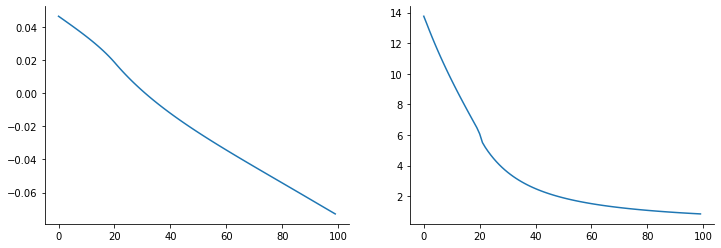

In [177]:
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(ϕ_2d[:,-1])
plt.subplot(122)
plt.plot(ems_2d[:,-1])

In [ ]:
import pandas as pd
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*μ/3
ℓ_step = 1e-15
ξₘ = 1000
ξₐ = 1000
ϕ_2d_dict = dict()
ems_2d_dict = dict()
for ℓ in [1e-12, 1e-6]:
    args = (δ, η, θ_list, σy, ℓ, γ1, γ2, γ3, ξₘ, ξₐ)
    ϕ_2d_dict[ℓ], ems_2d_dict[ℓ] = solve_with_constraint(y_grid, b_grid, args)
    args = (δ, η, θ_list, σy, ℓ+ℓ_step, γ1, γ2, γ3, ξₘ, ξₐ)
    ϕ_2d_dict[ℓ+ℓ_step], ems_2d_dict[ℓ_step] = solve_with_constraint(y_grid, b_grid, args)

0.8808268693443392
Episode 0: PDE Error: 0.002034205742; False Transient Error: 0.000608292971; Iterations: 10967; CG Error: 0.000000000098
End of PDE solver, takes time: 2.349670886993408
1.1907853491222947e-05
Episode 1: PDE Error: 0.002027643239; False Transient Error: 0.000606330779; Iterations: 10967; CG Error: 0.000000000098
End of PDE solver, takes time: 2.3402788639068604
1.1907853491009819e-05
Episode 2: PDE Error: 0.002021102596; False Transient Error: 0.000604374863; Iterations: 10967; CG Error: 0.000000000095
End of PDE solver, takes time: 2.3414905071258545
1.1907853490882965e-05
Episode 3: PDE Error: 0.002014582878; False Transient Error: 0.000602425214; Iterations: 10966; CG Error: 0.000000000100
End of PDE solver, takes time: 2.3562605381011963
1.1907853490736795e-05
Episode 4: PDE Error: 0.002008084048; False Transient Error: 0.000600481836; Iterations: 10959; CG Error: 0.000000000098
End of PDE solver, takes time: 2.33911395072937
1.1907853492989443e-05
Episode 5: PDE

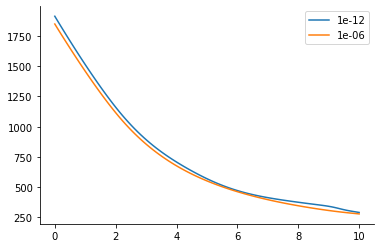

In [202]:
for ℓ in [1e-12, 1e-6]:
    plt.plot(y_grid, - (ϕ_2d_dict[ℓ+ℓ_step][:,-1] - ϕ_2d_dict[ℓ][:,-1])/ℓ_step, label="{}".format(ℓ))
plt.legend()